In [1]:
!git clone https://github.com/areed1192/portfolio-optimization.git


Cloning into 'portfolio-optimization'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 67 (delta 2), reused 0 (delta 0), pack-reused 63 (from 1)
Receiving objects: 100% (67/67), 285.17 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
%cd portfolio-optimization


/content/portfolio-optimization


In [3]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 64.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 97.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [4]:
pip install -e .


Obtaining file:///content/portfolio-optimization
  Preparing metadata (setup.py) ... done
  Using cached requests-2.24.0-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached matplotlib-3.3.0.tar.gz (38.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.22.0.zip (11.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-1.0.5.tar.gz (5.0 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

In [5]:
!pip install fake-useragent
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt

from pprint import pprint
from sklearn.preprocessing import StandardScaler
from fake_useragent import UserAgent
from pyopt.client import PriceHistory

pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.5 MB/s eta 0:00:00


In [6]:
import pathlib
symbols = ['AAPL', 'MSFT', 'SQ', 'AMZN']
number_of_symbols = len(symbols)

if not pathlib.Path(r"/content/portfolio-optimization/data/stock_data.csv").exists():

  price_history_client = PriceHistory(
      symbols=symbols, user_agent = UserAgent().edge
      )
  price_history_client.price_data_frame.to_csv(
      '/content/portfolio-optimization/data/stock_data.csv',
      index=False
  )
  pprint(price_history_client.price_data_frame)
  price_data_frame: pd.DataFrame = price_history_client.price_data_frame
  if not all(col in price_data_frame.columns for col in ['date', 'symbol', 'close']):
      print("Warning: Expected columns ('date', 'symbol', 'close') not found in PriceHistory data.")

      print("PriceHistory DataFrame columns:", price_data_frame.columns)

  price_data_frame[['date', 'symbol', 'close']].to_csv(
      '/content/portfolio-optimization/data/stock_data.csv',
      index=False
  )
  pprint(price_data_frame[['date', 'symbol', 'close']])

else:
  price_data_frame: pd.DataFrame = pd.read_csv(r'/content/portfolio-optimization/data/stock_data.csv')

  print("Columns after loading from CSV:", price_data_frame.columns)

price_data_frame = price_data_frame[['date', 'symbol', 'close']]
print(price_data_frame.head())



Columns after loading from CSV: Index(['date', 'close', 'volume', 'open', 'high', 'low', 'symbol'], dtype='object')
         date symbol   close
0  2020-07-23     SQ  122.93
1  2020-07-22     SQ  129.18
2  2020-07-21     SQ  126.99
3  2020-07-20     SQ  128.39
4  2020-07-17     SQ  120.73


In [7]:
price_data_frame = price_data_frame[['date', 'symbol', 'close']]


price_data_frame = price_data_frame.pivot(
    index='date', columns='symbol', values='close'
    )

price_data_frame = price_data_frame.reindex(columns=symbols)

display(price_data_frame)

symbol,AAPL,MSFT,SQ,AMZN
date,,,,
2020-01-24,318.31,165.04,71.14,NaN
2020-01-27,308.95,162.28,71.05,NaN
2020-01-28,317.69,165.46,74.80,NaN
2020-01-29,324.34,168.04,76.16,NaN
2020-01-30,323.87,172.78,76.10,NaN
...,...,...,...,...
2020-07-17,385.31,202.88,120.73,NaN
2020-07-20,393.43,211.60,128.39,NaN
2020-07-21,388.00,208.75,126.99,NaN


In [8]:
log_return = np.log(1 + price_data_frame.pct_change())

random_weights = np.array(np.random.random(len(log_return.columns)))
display(random_weights)
rebalance_weights = random_weights/np.sum(random_weights)

exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

exp_vol = np.sqrt(
    np.dot(
        rebalance_weights.T,
        np.dot(log_return.cov() * 252,
               rebalance_weights)
        )
)

sharpe_ratio = (exp_ret - 0.1)/exp_vol


weights_df = pd.DataFrame(data={
    'random_weights': random_weights,
    'rebalance_weights': rebalance_weights
})

print('')
print('=' * 80)
print('PORTFOLIO WEIGHTS:')
print('-' * 80)
print(weights_df)
print('-' * 80)


metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('=' * 80)
print('PORTFOLIO METRICS:')
print('-' * 80)
print(metrics_df)
print('-' * 80)

<ipython-input-8-fdcadb7ee9bf>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_return = np.log(1 + price_data_frame.pct_change())


array([0.47088574, 0.00321339, 0.42879374, 0.62654405])


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.470886           0.307882
1        0.003213           0.002101
2        0.428794           0.280361
3        0.626544           0.409657
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.405726                            NaN                     NaN
--------------------------------------------------------------------------------


In [9]:
num_of_portfolios = 3000
num_assets= len(log_return.columns)

all_weights= np.zeros((num_of_portfolios, number_of_symbols))
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)

log_return_cleaned = log_return.dropna()

for ind in range(num_of_portfolios):

  weights = np.random.random(num_assets)
  weights = weights/np.sum(weights)


  ret_arr[ind]= np.sum((log_return_cleaned.mean() * weights) * 252)

  vol_arr[ind] = np.sqrt(
      np.dot(
          weights.T,
          np.dot(log_return_cleaned.cov() * 252,
                 weights)
      )
  )

  sharpe_arr[ind] = (ret_arr[ind] - .01) / vol_arr[ind]

  all_weights[ind, :] = weights


simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

simulations_df = pd.DataFrame(data={
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'Portfolio Weights': list(all_weights)
})

simulations_df = simulations_df.infer_objects()

print('')
print('=' * 80)
print('SIMULATIONS RESULT:')
print('-' * 80)
print(simulations_df.head())
print('-' * 80)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



SIMULATIONS RESULT:
--------------------------------------------------------------------------------
   Returns  Volatility  Sharpe Ratio                                                                    Portfolio Weights
0      0.0         NaN           NaN   [0.17965274097146594, 0.14688518023103325, 0.5035177775938352, 0.1699443012036657]
1      0.0         NaN           NaN  [0.26165254606859073, 0.16398496242005234, 0.5014454430840565, 0.07291704842730051]
2      0.0         NaN           NaN  [0.01778895913779707, 0.5414398133362238, 0.27614426527980723, 0.16462696224617177]
3      0.0         NaN           NaN   [0.22749393518900612, 0.1512470202938377, 0.32187492302894716, 0.2993841214882089]
4      0.0         NaN           NaN    [0.28305139891383235, 0.3227298836217339, 0.210089192749971, 0.18412952471446276]
--------------------------------------------------------------------------------


In [10]:
if 'simulations_df' in locals() and not simulations_df.empty and not simulations_df['Sharpe Ratio'].dropna().empty:

    max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].dropna().idxmax()]

    min_volatility = simulations_df.loc[simulations_df['Volatility'].dropna().idxmin()]


    print('')
    print('=' * 80)
    print('MAX SHARPE RATIO:')
    print('-' * 80)
    print(max_sharpe_ratio)
    print('-' * 80)

    print('')
    print('=' * 80)
    print('MIN VOLATILITY:')
    print('-' * 80)
    print(min_volatility)
    print('-' * 80)
else:
    print("Cannot find max Sharpe Ratio or min Volatility: simulations_df is empty or 'Sharpe Ratio' or 'Volatility' columns contain only NaN values.")

Cannot find max Sharpe Ratio or min Volatility: simulations_df is empty or 'Sharpe Ratio' or 'Volatility' columns contain only NaN values.


Max Sharpe Ratio point cannot be plotted as it was not calculated.


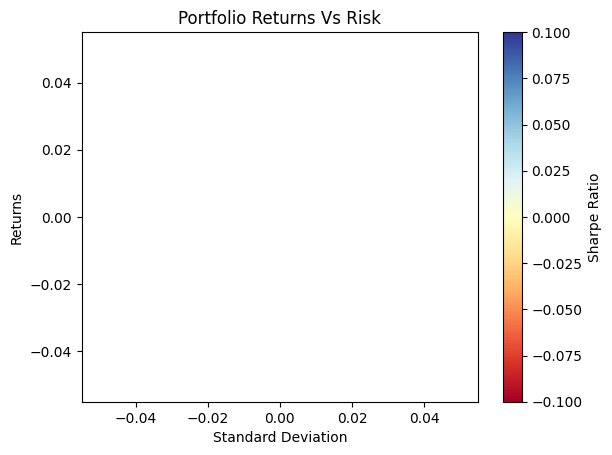

In [12]:
# %%
%matplotlib inline

plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

plt.title('Portfolio Returns Vs Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Check if max_sharpe_ratio was defined before attempting to plot it
if 'max_sharpe_ratio' in locals():
    plt.scatter(
        max_sharpe_ratio[1],
        max_sharpe_ratio[0],
        marker=(5,1,0),
        color='b',
        s=600
    )
else:
    print("Max Sharpe Ratio point cannot be plotted as it was not calculated.")


plt.show()

In [13]:
def get_metrics(weights: list) -> np.array:
  weights = np.array(weights)


  ret = np.sum((log_return_cleaned.mean() * weights) * 252)

  cov_matrix = log_return_cleaned.cov() * 252
  vol = np.sqrt(
        np.dot(weights.T, np.dot(cov_matrix, weights))
    )


  if vol == 0:
        sr = -np.inf
  else:
        sr = (ret - .01) / vol

  return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:

    metrics = get_metrics(weights)


    if np.isinf(metrics[2]):
        return metrics[2] * -1
    else:
        return metrics[2] * -1


def grab_volatility(weights: list) -> np.array:

    metrics = get_metrics(weights)
    return metrics[1]

def check_sum(weights: list) -> float:

    return np.sum(weights) - 1.0

In [14]:
bounds = tuple((0,1) for symbol in range(number_of_symbols))
cons = ({'type': 'eq', 'fun': check_sum})

init_guess = number_of_symbols * [1 / number_of_symbols]

optimized_sharpe = sci_plt.minimize(
      grab_negative_sharpe,
      init_guess,
      method='SLSQP',
      bounds=bounds,
      constraints=cons
  )

print('')
print('=' * 80)
print('OPTIMIZED SHARPE RATIO: ')
print('-' * 80)
print(optimized_sharpe)
print('-' * 80)


OPTIMIZED SHARPE RATIO: 
--------------------------------------------------------------------------------
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: nan
       x: [ 2.500e-01  2.500e-01  2.500e-01  2.500e-01]
     nit: 1
     jac: [       nan        nan        nan        nan]
    nfev: 5
    njev: 1
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [17]:
# %%
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
# Print the weights from the optimized_sharpe result
print(optimized_sharpe.x)
print('-' * 80)

print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
# Print the metrics calculated from the optimized weights
print(optimized_metrics)
print('-' * 80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.25 0.25 0.25 0.25]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[ 0. nan nan]
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [18]:
bounds = tuple((0,1) for symbol in range(number_of_symbols))
cons = ({'type': 'eq', 'fun': check_sum})

init_guess = number_of_symbols * [1 / number_of_symbols]

optimized_volatility = sci_plt.minimize(
      grab_volatility,
      init_guess,
      method='SLSQP',
      bounds=bounds,
      constraints=cons
  )

print('')
print('=' * 80)
print('OPTIMIZED VOLATILITY: ')
print('-' * 80)
print(optimized_volatility)
print('-' * 80)


OPTIMIZED VOLATILITY: 
--------------------------------------------------------------------------------
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: nan
       x: [ 2.500e-01  2.500e-01  2.500e-01  2.500e-01]
     nit: 1
     jac: [       nan        nan        nan        nan]
    nfev: 5
    njev: 1
--------------------------------------------------------------------------------


In [20]:
if 'simulations_df' in locals() and not simulations_df.empty and not simulations_df['Sharpe Ratio'].dropna().empty:

    max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].dropna().idxmax()]

    min_volatility = simulations_df.loc[simulations_df['Volatility'].dropna().idxmin()]


    print('')
    print('=' * 80)
    print('MAX SHARPE RATIO:')
    print('-' * 80)
    print(max_sharpe_ratio)
    print('-' * 80)

    print('')
    print('=' * 80)
    print('MIN VOLATILITY:')
    print('-' * 80)
    print(min_volatility)
    print('-' * 80)
else:
    print("Cannot find max Sharpe Ratio or min Volatility: simulations_df is empty or 'Sharpe Ratio' or 'Volatility' columns contain only NaN values.")

Cannot find max Sharpe Ratio or min Volatility: simulations_df is empty or 'Sharpe Ratio' or 'Volatility' columns contain only NaN values.
